# Language Understang System - midterm project
## University of Trento - A.Y. 2019 / 2020

Davide Zanella - 211463

----
The full code can be found on github: https://github.com/davidezanella/LUS-midterm-project

**Warning**: The execution of the whole Notebook will take some hours to complete

In [7]:
# to import conll
import os
import subprocess
import sys
sys.path.insert(0, os.path.abspath('./src/'))

from conll import evaluate
# for nice tables
import pandas as pd

from tqdm.notebook import tqdm

In [8]:
def execute(cmd):
    return subprocess.check_output(cmd, shell=True).decode(sys.stdout.encoding)

In [9]:
# Let's define a function to simplify working with data
# get column from loaded corpus (tokens are tuples)
def get_column(corpus, column=-1):
    return [[word[column] for word in sent] for sent in corpus]

In [10]:
# modified version to support fst-output
def read_fst4conll(fst_file, fs="\t", oov='<unk>', otag='O', sep='+', split=False):
    """
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :param oov: token to map to otag (we need to get rid of <unk> in labels)
    :param otag: otag symbol
    :param sep: 
    :param split:
    :return: corpus 
    """
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(temp_folder + fst_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            # arc has minimum 3 columns, else final state
            if len(feats) >= 3:
                ist = feats[2]  # 3rd column (input)
                ost = feats[3]  # 4th column (output)
                # replace '<unk>' with 'O'
                ost = otag if ost == oov else ost
                # ignore for now
                ost = ost.split(sep)[1] if split and ost != otag else ost
                
                words.append((ist, ost))
            else:
                sents.append(words)
                words = []
        else:
            if len(words) > 0:
                sents.append(words) 
                words = []
    return sents

In [11]:
def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents

In [12]:
def compute_frequency_list(corpus):
    """
    create frequency list for a corpus
    :param corpus: corpus as list of lists
    """
    frequencies = {}
    for sent in corpus:
        for token in sent:
            frequencies[token] = frequencies.setdefault(token, 0) + 1
    return frequencies

In [13]:
def cutoff(corpus, tf_min=2):
    """
    apply min cutoffs
    :param tf_min: minimum token frequency for lexicon elements (below removed); default 2
    :return: lexicon as set
    """
    frequencies = compute_frequency_list(corpus)
    return sorted([token for token, frequency in frequencies.items() if frequency >= tf_min])

In [14]:
temp_folder = 'tmp/'
wdir = temp_folder + 'wdir_wt/'

In [833]:
dpath = 'dataset/'

def init():
    execute('mkdir -p ' + temp_folder)

    execute('cp {}NL2SparQL4NLU.train.utterances.txt {}trn.txt'.format(dpath, temp_folder))
    execute('cp {}NL2SparQL4NLU.test.utterances.txt {}tst.txt'.format(dpath, temp_folder))

    execute('cp {}NL2SparQL4NLU.train.conll.txt {}trn.conll'.format(dpath, temp_folder))
    execute('cp {}NL2SparQL4NLU.test.conll.txt {}tst.conll'.format(dpath, temp_folder))

    execute('cp {}NL2SparQL4NLU.train.features.conll.txt {}pos.tag.conll'.format(dpath, temp_folder))

In [834]:
init()

## Input generalization functions

Download the dataset for spacy with the following command:

`python -m spacy download en_core_web_sm`

In [1053]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [26]:
norm_rules = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE',
              'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

In [621]:
def normalize_dataset(inp_conll, out_conll, out_conll_succ, out_txt, out_osyms, out_trn_wt, rules, t_isyms, t_osyms):
    lines = []
    lines_txt = []
    
    lines_succ_conll = []
    
    osyms = []
        
    f_pos = open('dataset/NL2SparQL4NLU.train.features.conll.txt', "r")
    pos_lines = [ l.split('\t') for l in f_pos.readlines() ]
    i = -1


    # conll processing
    f = open(temp_folder + inp_conll, "r")
    words = []
    words_succ = []
    for line in f.readlines():
        i += 1
        if line == '\n':
            phrase = ' '.join([w[0] for w in words])
            doc = nlp(phrase)
            
            for ent in doc.ents:
                if ent.label_ in rules:
                    cnt = 0
                    for el in range(len(words)):
                        wrd = words[el][0]
                        if cnt >= ent.start_char and cnt <= ent.end_char:
                            pos_tag = pos_lines[i - len(words) + el][1]
                            
                            words[el][1] = ent.label_# + '|' + pos_tag
                            words_succ[el][0] = ent.label_ #+ '|' + pos_tag
                            #if '|' in words_succ[el][1]:  # change successive O-tag replacement
                                #words_succ[el][1] = ent.label_ + words_succ[el][1].split('|')[1]
                        cnt += len(wrd) + 1  # 1 extra for the space
                        
            for w in range(len(words)):
                #if words[w][1][:2] in ['B-', 'I-']:
                    #pos_tag = pos_lines[i - len(words) + w][1]
                    
                    #words[w][1] = words[w][0] + '|' + pos_tag
                words_succ[w][0] = words[w][1].split('\n')[0]

            
            osyms += [w[0].split('\n')[0] for w in words_succ]
            osyms += [w[1].split('\n')[0] for w in words_succ]
            
            for w in words:
                if w[1][-1] != '\n':
                    w[1] += '\n'
            for w in words_succ:
                if w[1][-1] != '\n':
                    w[1] += '\n'
               
            
            new_line = ['\t'.join(l) for l in words]
            
            lines += new_line + ['\n']
            lines_succ_conll += ['\t'.join(l) for l in words_succ] + ['\n']
            
            lines_txt.append(' '.join([w[1][:-1] for w in words]) + '\n')
            
            words = []
            words_succ = []
        else:
            words.append(line.split('\t'))
            words_succ.append(line.split('\t'))
        
    with open(temp_folder + out_conll, 'w') as f:
        for s in lines:
            f.write(s)
            
    with open(temp_folder + out_conll_succ, 'w') as f:
        for s in lines_succ_conll:
            f.write(s)
            
    #new train dt
    with open(temp_folder + out_trn_wt, 'w') as f:
        for s in lines_succ_conll:
            if s == '\n':
                f.write(s)
            else:
                wt = s.split('\t')[1]
                ''.join(wt.split(' '))
                f.write(wt[:-1] + ' ')
            
    #txt saving        
    with open(temp_folder + out_txt, 'w') as f:
        for s in lines_txt:
            f.write(s)
            
    #osyms saving
    osyms = list(set(osyms))#t_isyms + norm_rules
    with open(temp_folder + 'osyms_norm.t.lst.txt', 'w') as f:
        for s in osyms:
            if s.split('|')[0] in norm_rules or s in t_osyms:
                f.write(s + '\n')
            
    return osyms

## SCLM functions

### My custom classes

In [1027]:
from enum import IntEnum, Enum

class Baseline(IntEnum):
    none = 0
    random_path = 1
    output_symbol_priors = 2
    MLE = 3
    

class NgramMethod(Enum):
    katz = 'katz'
    katz_frac = 'katz_frac'
    presmoothed = 'presmoothed'
    unsmoothed = 'unsmoothed'
    absolute = 'absolute'
    kneser_ney = 'kneser_ney'
    witten_bell = 'witten_bell'

In [799]:
class Symbols:
    def __init__(self, file_name):
        self.file_name = file_name
        self.values = []
        
        self.oov = '<unk>'  # unknown symbol
        self.fs = " "       # wfst specification column separator
        
        
    def load(self):
        with open(temp_folder + self.file_name, 'r') as f:
            self.values = [ l.split('\t')[0] for l in f.readlines() ]
    
    
    def set_symbols(self, values):
        self.values = sorted(list(set(values)))
        
        
    def _get_list_file_name(self):
        return self.file_name + '.lst'
        
        
    def save_list(self):
        with open(temp_folder + self._get_list_file_name(), 'w+') as f:
            for i in range(len(self.values)):
                f.write('{0}\n'.format(self.values[i]))
                
    
    def compile(self):
        self.save_list()
        execute('ngramsymbols {0}{1} {0}{2}'.format(temp_folder, self._get_list_file_name(), self.file_name))
        
        
    def join_symbols(self, osymbols, file_name):
        join_symbols = Symbols(file_name + '.syms')
        join_symbols.set_symbols(self.values + osymbols.values)
        join_symbols.compile()        
        
        with open(temp_folder + file_name, 'w') as f:
            for osym in osymbols.values + [self.oov]:
                for isym in self.values + [self.oov]:
                    line = [ osym, isym ]
                    f.write(self.fs.join(line) + "\n")
        
        return join_symbols

In [1075]:
import copy


class Conll:
    def __init__(self, file_name, wt=False):
        self.file_name = file_name
        self.isymbols = None
        self.osymbols = None
        self.sentences = []
        
        self.wt = wt
    
    
    def load(self):
        with open(temp_folder + self.file_name, 'r') as f:
            sentences = f.read().split('\n\n')
            sentences = [ l.split('\n') for l in sentences ]
            self.sentences = [ [ w.split('\t') for w in  l ] for l in sentences ]

        self.sentences = list(filter(lambda i : i != [['']], self.sentences))

        self.find_symbols()
        
        return self
    
    
    def save(self):
        with open(temp_folder + self.file_name, 'w+') as f:
            for s in self.sentences:
                for w in s:
                    f.write('{0}\t{1}\n'.format(w[0], w[1]))
                f.write('\n')
        
        return self

        
    def set_isymbols(self, values):
        self.isymbols = Symbols(self.file_name + '.isyms')
        self.isymbols.set_symbols(list(set(values)))
        self.isymbols.compile()


    def set_osymbols(self, values):
        self.osymbols = Symbols(self.file_name + '.osyms')
        self.osymbols.set_symbols(list(set(values)))
        self.osymbols.compile()
    
    
    def find_symbols(self):
        isyms = [ w[0] for s in self.sentences for w in s ]
        self.set_isymbols(isyms)
        osyms = [ w[1] for s in self.sentences for w in s ]
        
        if self.wt:
            osyms = [ isyms[i] + '+' + osyms[i] for i in range(len(isyms)) ]

        self.set_osymbols(osyms)
    
    
    def apply_cutoff(self, min_freq):        
        wt_sents = [[ "+".join(w) for w in s ] for s in self.sentences ]
        wt_cutted_off = cutoff(wt_sents, min_freq)
        
        self.set_isymbols([ w.split('+')[0] for w in wt_cutted_off ])
        
        orig_osyms = [ w.split('+')[1] for w in wt_cutted_off ]
        if self.wt:
            self.set_osymbols(wt_cutted_off)
        else:
            self.set_osymbols(orig_osyms)

        return self
    
    
    def _get_dt_filename(self):
        return self.file_name + '.dt'
    
    
    def create_dataset(self):
        with open(temp_folder + self._get_dt_filename(), 'w') as f:
            for s in self.sentences:
                if self.wt:
                    line = ' '.join([ w[0] + '+' + w[1] for w in s ])
                else:
                    line = ' '.join([ w[1] for w in s ])
                f.write(line + '\n')
        return self._get_dt_filename()
    
    
    def clone_reversed(self, file_name):
        reverse = Conll(file_name, wt=self.wt)
        
        reverse.isymbols = self.osymbols
        reverse.osymbols = self.isymbols
        reverse.sentences = [ [ list(reversed(w)) for w in s ] for s in self.sentences ]
        
        reverse.save()
        
        return reverse
    
    
    def remove_OoS(self, pos_conll):
        wo_oos_first = Conll(self.file_name + '.wo_oos1', wt=self.wt)
        wo_oos_second = Conll(self.file_name + '.wo_oos2', wt=self.wt)
        
        wo_oos_first.sentences = copy.deepcopy(self.sentences)
        wo_oos_second.sentences = copy.deepcopy(self.sentences)
        osymbols = set()
        
        for s in range(len(wo_oos_first.sentences)):
            for w in range(len(wo_oos_first.sentences[s])):
                if wo_oos_first.sentences[s][w][1] == 'O':
                    pos_tag = pos_conll.sentences[s][w][1]
                    wo_oos_first.sentences[s][w][1] = wo_oos_first.sentences[s][w][0] + '|' + pos_tag                    
                    
                    osymbols.add(wo_oos_first.sentences[s][w][1])
                elif wo_oos_first.sentences[s][w][1] in self.osymbols.values:
                    osymbols.add(wo_oos_first.sentences[s][w][1])
                wo_oos_second.sentences[s][w][0] = wo_oos_first.sentences[s][w][1]

        wo_oos_first.isymbols = self.isymbols
        wo_oos_first.set_osymbols(osymbols)
        
        
        wo_oos_second.isymbols = wo_oos_first.osymbols
        wo_oos_second.osymbols = self.osymbols
        
        
        wo_oos_first.save()
        wo_oos_second.save()
        
        return wo_oos_first, wo_oos_second
    
    
    def remove_OoS_and_POS(self, pos_conll):
        wo_oos_first = Conll(self.file_name + '.wo_oos1', wt=self.wt)
        wo_oos_second = Conll(self.file_name + '.wo_oos2', wt=self.wt)
        wo_oos_third = Conll(self.file_name + '.wo_oos3', wt=self.wt)
        
        wo_oos_first.sentences = copy.deepcopy(self.sentences)
        wo_oos_second.sentences = copy.deepcopy(self.sentences)
        wo_oos_third.sentences = copy.deepcopy(self.sentences)
        
        first_osymbols = set()
        second_osymbols = set()
        
        
        for s in range(len(wo_oos_first.sentences)):
            for w in range(len(wo_oos_first.sentences[s])):
                pos_tag = pos_conll.sentences[s][w][1]
                
                wo_oos_first.sentences[s][w][1] = wo_oos_first.sentences[s][w][0] + '|' + pos_tag
                wo_oos_second.sentences[s][w][0] = wo_oos_first.sentences[s][w][1]
                if self.sentences[s][w][0] in self.isymbols.values:
                    first_osymbols.add(wo_oos_second.sentences[s][w][0])
                
                if self.sentences[s][w][1] == 'O':
                    wo_oos_second.sentences[s][w][1] = wo_oos_first.sentences[s][w][0] + '|O'
                    wo_oos_third.sentences[s][w][0] = wo_oos_first.sentences[s][w][0] + '|O'
                    
                    if self.sentences[s][w][0] in self.isymbols.values:
                        second_osymbols.add(wo_oos_second.sentences[s][w][1])
                elif self.sentences[s][w][1] in self.osymbols.values:
                    wo_oos_third.sentences[s][w][0] = wo_oos_second.sentences[s][w][1]
                    
                    second_osymbols.add(wo_oos_second.sentences[s][w][1])

        wo_oos_first.isymbols = self.isymbols
        wo_oos_first.set_osymbols(first_osymbols)
        
        wo_oos_second.isymbols = wo_oos_first.osymbols
        wo_oos_second.set_osymbols(second_osymbols)
        
        wo_oos_third.isymbols = wo_oos_second.osymbols
        wo_oos_third.osymbols = self.osymbols
        
        
        wo_oos_first.save()
        wo_oos_second.save()
        wo_oos_third.save()
        
        return wo_oos_first, wo_oos_second, wo_oos_third
    
    
    def remove_OoS_POS_norm(self, pos_conll):
        norm_first = Conll(self.file_name + '.norm1', wt=self.wt)
        norm_second = Conll(self.file_name + '.norm2', wt=self.wt)
        norm_third = Conll(self.file_name + '.norm3', wt=self.wt)
        norm_forth = Conll(self.file_name + '.norm4', wt=self.wt)
        
        norm_first.sentences = copy.deepcopy(self.sentences)
        norm_second.sentences = copy.deepcopy(self.sentences)
        norm_third.sentences = copy.deepcopy(self.sentences)
        norm_forth.sentences = copy.deepcopy(self.sentences)
        
        first_osymbols = set()
        second_osymbols = set()
        third_osymbols = set()
        
        
        for s in range(len(self.sentences)):
            phrase = ' '.join([w[0] for w in self.sentences[s]])
            doc = nlp(phrase)
            norm_words = copy.deepcopy(self.sentences[s])
            
            for ent in doc.ents:
                cnt = 0
                for el in range(len(norm_words)):
                    wrd = norm_words[el][0]
                    if cnt >= ent.start_char and cnt <= ent.end_char:
                        norm_words[el][0] = ent.label_
                    cnt += len(wrd) + 1  # 1 extra for the space
            
            for w in range(len(self.sentences[s])):
                pos_tag = pos_conll.sentences[s][w][1]
                norm_word = pos_conll.sentences[s][w][2]
                
                norm_first.sentences[s][w][1] = norm_word + '|' + pos_tag  # norm_first.sentences[s][w][0]
                norm_second.sentences[s][w][0] = norm_first.sentences[s][w][1]
                if self.sentences[s][w][0] in self.isymbols.values:
                    first_osymbols.add(norm_second.sentences[s][w][0])
                
                norm_second.sentences[s][w][1] = norm_words[w][0] + '|' + pos_tag
                norm_third.sentences[s][w][0] = norm_second.sentences[s][w][1]
                if self.sentences[s][w][0] in self.isymbols.values or \
                        norm_words[w][0] in norm_rules:
                    second_osymbols.add(norm_second.sentences[s][w][1])
                
                if self.sentences[s][w][1] == 'O':
                    norm_third.sentences[s][w][1] = norm_first.sentences[s][w][0] + '|O'
                    norm_forth.sentences[s][w][0] = norm_third.sentences[s][w][1]
                    
                    if self.sentences[s][w][0] in self.isymbols.values:
                        third_osymbols.add(norm_third.sentences[s][w][1])
                elif self.sentences[s][w][1] in self.osymbols.values:
                    norm_forth.sentences[s][w][0] = norm_third.sentences[s][w][1]
                    
                    third_osymbols.add(norm_third.sentences[s][w][1])

        norm_first.isymbols = self.isymbols
        norm_first.set_osymbols(first_osymbols)
        
        norm_second.isymbols = norm_first.osymbols
        norm_second.set_osymbols(second_osymbols)
        
        norm_third.isymbols = norm_second.osymbols
        norm_third.set_osymbols(third_osymbols)
        
        norm_forth.isymbols = norm_third.osymbols
        norm_forth.osymbols = self.osymbols
        
        
        norm_first.save()
        norm_second.save()
        norm_third.save()
        norm_forth.save()
        
        return norm_first, norm_second, norm_third, norm_forth

In [1016]:
class FST:
    def __init__(self, file_name, isymbols=None, osymbols=None):
        self.file_name = file_name
        self.isymbols = isymbols
        self.osymbols = osymbols
        
        self.chain = None

    
    def compile(self, input_file):
        execute('fstcompile --isymbols={0}{1} --osymbols={0}{2} --keep_isymbols --keep_osymbols \
            {0}{3} {0}{4}'.format(temp_folder, self.isymbols.file_name, self.osymbols.file_name, 
                                  input_file, self.file_name))
        return self
        
    
    def compose(self, fst, out_filename):
        execute('fstcompose {0}{1} {0}{2} {0}{3}'.format(temp_folder,
                     self.file_name, fst.file_name, out_filename))
        return FST(out_filename, self.isymbols, fst.osymbols)
    
    def compose_chain(self, fst):
        if self.chain is None:
            self.chain = 'fstcompose {0}{1} {0}{2}'.format(temp_folder, self.file_name, fst.file_name)
        else:
            self.chain += ' | fstcompose - {0}{1}'.format(temp_folder, fst.file_name)
        
        return self
    
    
    def invert(self):
        execute('fstinvert {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    
    def arcsort(self):
        execute('fstarcsort {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    
    def rmepsilon(self):
        execute('fstrmepsilon {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def rmepsilon_chain(self):
        if self.chain is None:
            self.chain = 'fstrmepsilon'
        else:
            self.chain += ' | fstrmepsilon'
        
        return self
    
    
    def shortestpath(self):
        execute('fstshortestpath {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def shortestpath_chain(self):
        if self.chain is None:
            self.chain = 'fstshortestpath'
        else:
            self.chain += ' | fstshortestpath'
        
        return self
    
    
    def topsort(self):
        execute('fsttopsort {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def topsort_chain(self):
        if self.chain is None:
            self.chain = 'fsttopsort'
        else:
            self.chain += ' | fsttopsort'
        
        return self
    
    
    def randgen(self):
        execute('fstrandgen {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def randgen_chain(self):
        if self.chain is None:
            self.chain = 'fstrandgen'
        else:
            self.chain += ' | fstrandgen'
        
        return self
    
    
    def info(self):
        lines = execute('fstinfo {0}{1}'.format(temp_folder, self.file_name)).split('\n')
        info = [list(filter(None, x.split('  '))) for x in lines]
        return info
    
    
    def print(self):
        return execute('fstprint {0}{1}'.format(temp_folder, self.file_name))
    
    def print_chain(self):
        instr = 'fstprint --isymbols={0}{1} --osymbols={0}{2}'.format(
                            temp_folder, self.isymbols.file_name, self.osymbols.file_name)
        if self.chain is None:
            self.chain = instr
        else:
            self.chain += ' | ' + instr
        
        return self
    
    
    def execute_chain(self):
        return execute(self.chain)

In [992]:
class Ngram:
    def __init__(self, file_name, symbols, method='katz', degree=2):
        self.file_name = file_name
        self.symbols = symbols        
        self.isymbols = symbols
        self.osymbols = symbols
        self.method = method
        self.degree = degree
        
        self.special = {'<epsilon>', '<s>', '</s>'}
        self.oov = '<unk>'  # unknown symbol
        self.state = '0'    # wfst specification state
        self.fs = " "       # wfst specification column separator
        self.otag = 'O'
        
        
    def _get_FAR_filename(self):
        return self.file_name + '.far'
        
        
    def _get_count_filename(self):
        return self.file_name + '.cnt'
        
    
    def train_from_dataset(self, dataset_file):
        self.compile_strings(dataset_file)

        execute('ngramcount --order={1} {0}{2} {0}{3}'
                .format(temp_folder, self.degree, self._get_FAR_filename(), self._get_count_filename()))
        execute('ngrammake --method={1} {0}{2} {0}{3}'
                .format(temp_folder, self.method, self._get_count_filename(), self.file_name))
        
        return self
        
    
    def _get_probs_filename(self):
        return self.file_name + '.probs'
    
    
    def calc_neglog_probs(self):
        execute('ngramprint --symbols={0}{1} --negativelogs \
            {0}{2} {0}{3}'.format(temp_folder, self.symbols.file_name, self.file_name, self._get_probs_filename()))
        
        
    def compile_strings(self, dataset_file):
        execute("farcompilestrings --symbols={0}{1} --keep_symbols --unknown_symbol='<unk>' \
            {0}{2} {0}{3}".format(temp_folder, self.symbols.file_name, dataset_file, self._get_FAR_filename()))
        
        
    def extract_far(self):
        execute('rm -r -f ' + wdir)
        execute('mkdir ' + wdir)

        execute('farextract --filename_prefix="{1}" {0}{2}'.format(temp_folder, wdir, self._get_FAR_filename()))
    
    
    def _get_fst_filename(self):
        return self.file_name + '.fst'
    
    
    def _create_FST(self, isymbols, osymbols):
        fst = FST(self._get_fst_filename(), isymbols, osymbols)
        return fst.compile(self._get_fst_desc_filename()).arcsort()
    
    
    def _get_fst_desc_filename(self):
        return self.file_name + '.desc.fst'
    
    
    def create_FST_w2t_wt(self, isymbols, osymbols):
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f:
            for sym in self.symbols.values + [self.oov]:
                line = [ self.state, self.state, sym.split('+')[0], sym ]
                f.write(self.fs.join(line) + "\n")
                
            f.write(self.state + "\n")
        
        return self._create_FST(isymbols, osymbols)
    
    
    def create_FST_w2t(self, isymbols, osymbols):
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f:
            for isym in isymbols.values + [self.oov]:
                for osym in osymbols.values + [self.oov]:
                    line = [ self.state, self.state, isym, osym ]
                    f.write(self.fs.join(line) + "\n")
                
            f.write(self.state + "\n")
        
        return self._create_FST(isymbols, osymbols)
    
    
    def create_FST_w2t_MLE(self, isymbols, osymbols):
        self.calc_neglog_probs()
        
        lines = [ line.strip().split("\t") for line in open(temp_folder + self._get_probs_filename(), 'r') ]
    
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f:
            for line in lines:
                ngram = line[0]
                ngram_words = ngram.split()  # by space
                if len(ngram_words) == 2:
                    if set(ngram_words).isdisjoint(set(self.special)):
                        if ngram_words[0] in [self.otag, self.oov]:
                            f.write(self.fs.join([self.state, self.state] + ngram_words + [line[1]]) + "\n")
                        elif ngram_words[0] in osymbols.values: #and \
                                #ngram_words[1] in isymbols.values + [self.oov]:                            
                            f.write(self.fs.join([self.state, self.state] + line) + "\n")
                        else:
                            print("missing", ngram_words)
                            #f.write(self.fs.join([self.state, self.state] + [self.oov, self.oov] + [line[1]]) + "\n")
                
            f.write(self.state + "\n")
        
        return self._create_FST(osymbols, isymbols).invert()
    
    
    def create_FST_readd_OoS(self, isymbols, osymbols, wt):
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f: 
            for token in isymbols.values + [self.oov]:
                if self.oov in token:                    
                    line = [self.state, self.state, token, token]
                elif 'I-' in token or 'B-' in token: #or  or '+O' == token[-2:]:
                    new_token = token.split('|')[0]
                    line = [self.state, self.state, token, token] #new_token
                else:
                    new_token = 'O'
                    if wt:
                        new_token = token.split('+')[0] + '+O'
                    line = [self.state, self.state, token, new_token]

                f.write(self.fs.join(line) + "\n")
            f.write(self.state + "\n")
            
        return self._create_FST(isymbols, osymbols)
    
    
    def info(self):
        lines = execute('ngraminfo {0}{1}'.format(temp_folder, self.file_name)).split('\n')
        info = [list(filter(None, x.split('  '))) for x in lines][:-3]
        return info

In [1036]:
class Evaluation:
    def __init__(self, isymbols, osymbols, dataset, refs_file, baseline:Baseline, tqdm=False, wt=False):
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.dataset = dataset
        self.refs_file = refs_file
        self.baseline = baseline
        
        self.wt = wt
        self.tqdm = tqdm
        
        self.wdir_folder = os.path.basename(os.path.dirname(wdir)) + '/'
    
    
    def evaluate_fst(self, fst_filename, trans_fst, model, readd_oos_fst=None, model_oos=None, readd_oos_fst2=None,
                     model_oos2=None, readd_oos_fst3=None, model_oos3=None):
        fst = FST(self.wdir_folder + fst_filename, self.isymbols, self.osymbols)
            
        fst = fst.compose_chain(trans_fst)
        fst = fst.compose_chain(model)

        if readd_oos_fst is not None:
            fst = fst.shortestpath_chain()
            fst = fst.rmepsilon_chain()
            fst = fst.topsort_chain()
            fst = fst.compose_chain(readd_oos_fst)
            fst = fst.compose_chain(model_oos)

        if readd_oos_fst2 is not None:
            fst = fst.shortestpath_chain()
            fst = fst.rmepsilon_chain()
            fst = fst.topsort_chain()
            fst = fst.compose_chain(readd_oos_fst2)
            fst = fst.compose_chain(model_oos2)

        if readd_oos_fst3 is not None:
            fst = fst.shortestpath_chain()
            fst = fst.rmepsilon_chain()
            fst = fst.topsort_chain()
            fst = fst.compose_chain(readd_oos_fst3)
            fst = fst.compose_chain(model_oos3)

        if self.baseline == Baseline.random_path:
            fst = fst.randgen_chain()
        else:
            fst = fst.shortestpath_chain()

        fst = fst.rmepsilon_chain()
        fst = fst.topsort_chain()

        fst = fst.print_chain()
        
        res = fst.execute_chain()

        assert res != '', 'Something wrong while composing file {}'.format(fst_filename)
        
        return res
    
    
    def evaluate(self, trans_fst, model, readd_oos_fst=None, model_oos=None, readd_oos_fst2=None, model_oos2=None,
                readd_oos_fst3=None, model_oos3=None):
        ev = Ngram('evaluation', self.isymbols)
        ev.compile_strings(self.dataset)
        ev.extract_far()
        
        fst_files = [ f for f in os.listdir(wdir) if os.path.isfile(os.path.join(wdir, f)) ]
        
        
        fst_out = ''
        
        fst_files = sorted(fst_files)
        if self.tqdm:
            fst_files = tqdm(fst_files)
        
        for f in fst_files:
            fst_out += self.evaluate_fst(f, trans_fst, model, readd_oos_fst, model_oos, readd_oos_fst2, model_oos2,
                                        readd_oos_fst3, model_oos3)

        hyps_file = 'result.out'

        with open(temp_folder + hyps_file, 'w+') as f:
            f.write(fst_out)

        return evaluate_fst(True, self.refs_file, hyps_file, self.wt)

In [978]:
baseline = Baseline.none

trn_conll = Conll('trn.conll', wt=True).load()
trn_conll.apply_cutoff(2)
dt = trn_conll.create_dataset()

model = Ngram('model.lm', trn_conll.osymbols)
model.train_from_dataset(dt)
trans_fst = model.create_FST_w2t_wt(trn_conll.isymbols, trn_conll.osymbols)


ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=True, tqdm=True)
ris = ev.evaluate(trans_fst, model)
ris['f1'], ris['acc'], ris['prec'], ris['recall']

(0.7238095238095239, 0.9158353238724182, 0.7532210109018831, 0.696608615948671)

In [938]:
baseline = Baseline.random_path

wt = baseline in [ Baseline.none, Baseline.random_path ]

trn_conll = Conll('trn.conll', wt=wt).load()
trn_conll.apply_cutoff(2)
dt = trn_conll.create_dataset()


model = Ngram('model.lm', trn_conll.osymbols)
model.train_from_dataset(dt)
trans_fst = model.create_FST_w2t(trn_conll.isymbols, trn_conll.osymbols)


ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
ris = ev.evaluate(trans_fst, model)
ris['f1'], ris['acc'], ris['prec'], ris['recall']

(0.01974913263944489,
 0.3951102992834059,
 0.013930722891566265,
 0.03391384051329056)

In [939]:
baseline = Baseline.output_symbol_priors

wt = baseline in [ Baseline.none, Baseline.random_path ]

trn_conll = Conll('trn.conll', wt=wt).load()
trn_conll.apply_cutoff(2)
dt = trn_conll.create_dataset()

model = Ngram('model.lm', trn_conll.osymbols, 'absolute', 4)
model.train_from_dataset(dt)
trans_fst = model.create_FST_w2t(trn_conll.isymbols, trn_conll.osymbols)


ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
ris = ev.evaluate(trans_fst, model)
ris['f1'], ris['acc'], ris['prec'], ris['recall']

(0.12604628261939932,
 0.6535056905999719,
 0.13617021276595745,
 0.11732355637030248)

In [940]:
baseline = Baseline.MLE

wt = baseline in [ Baseline.none, Baseline.random_path ]

trn_conll = Conll('trn.conll', wt=wt).load()
trn_conll.apply_cutoff(2)
dt = trn_conll.create_dataset()

model = Ngram('model.lm', trn_conll.osymbols, 'absolute', 4)
model.train_from_dataset(dt)


trn_reversed = trn_conll.clone_reversed('trn_reversed.conll')

trn_filename = 'trn.mle.txt'
msyms = trn_conll.isymbols.join_symbols(trn_conll.osymbols, trn_filename)

model_prob = Ngram('model_prob.lm', msyms)
model_prob.train_from_dataset(trn_reversed.file_name)

trans_fst = model_prob.create_FST_w2t_MLE(trn_conll.isymbols, trn_conll.osymbols)


ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
ris = ev.evaluate(trans_fst, model)
ris['f1'], ris['acc'], ris['prec'], ris['recall']

(0.7233848953594177,
 0.9154137979485738,
 0.7181571815718157,
 0.7286892758936755)

In [936]:
baseline = Baseline.MLE

wt = baseline in [ Baseline.none, Baseline.random_path ]

trn_conll = Conll('trn.conll', wt=wt).load()
trn_conll.apply_cutoff(2)

trn_pos = Conll('pos.tag.conll', wt=False).load()
trn_conll_wo_oos, _ = trn_conll.remove_OoS(trn_pos)

dt = trn_conll_wo_oos.create_dataset()

model = Ngram('model.lm', trn_conll_wo_oos.osymbols, 'kneser_ney', 4)
model.train_from_dataset(dt)


trn_reversed = trn_conll_wo_oos.clone_reversed('trn_reversed.conll')

trn_filename = 'trn.mle.txt'
msyms = trn_conll_wo_oos.isymbols.join_symbols(trn_conll_wo_oos.osymbols, trn_filename)

model_prob = Ngram('model_prob.lm', msyms, 'absolute')
model_prob.train_from_dataset(trn_reversed.file_name)

trans_fst = model_prob.create_FST_w2t_MLE(trn_conll.isymbols, trn_conll_wo_oos.osymbols)

model_readd_oos = Ngram('model_readd_oos.lm', msyms)
readd_oos_fst = model_readd_oos.create_FST_readd_OoS(trn_conll_wo_oos.osymbols, trn_conll.osymbols, wt=wt)


ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
ris = ev.evaluate(trans_fst, model, readd_oos_fst)
ris['f1'], ris['acc'], ris['prec'], ris['recall']

(0.807503349709692, 0.9416889138682029, 0.7874564459930313, 0.8285976168652612)

In [979]:
baseline = Baseline.MLE

wt = baseline in [ Baseline.none, Baseline.random_path ]

trn_conll = Conll('trn.conll', wt=wt).load()
trn_conll.apply_cutoff(2)

trn_pos = Conll('pos.tag.conll', wt=False).load()
trn_conll_wo_oos, wo_oos_second = trn_conll.remove_OoS(trn_pos)

dt = trn_conll_wo_oos.create_dataset()

model = Ngram('model.lm', trn_conll_wo_oos.osymbols, 'kneser_ney', 4)
model.train_from_dataset(dt)


trn_reversed = trn_conll_wo_oos.clone_reversed('trn_reversed.conll')

trn_filename = 'trn.mle.txt'
msyms = trn_conll_wo_oos.isymbols.join_symbols(trn_conll_wo_oos.osymbols, trn_filename)

model_prob = Ngram('model_prob.lm', msyms, 'absolute')
model_prob.train_from_dataset(trn_reversed.file_name)

trans_fst = model_prob.create_FST_w2t_MLE(trn_conll_wo_oos.isymbols, trn_conll_wo_oos.osymbols)

####################


dt = wo_oos_second.create_dataset()

model_readd_oos = Ngram('model_readd_oos.lm', wo_oos_second.osymbols, 'kneser_ney', 4)
model_readd_oos.train_from_dataset(dt)


trn_reversed = wo_oos_second.clone_reversed('trn_wo_oos_reversed.conll')

trn_filename = 'trn_wo_oos.mle.txt'
msyms = wo_oos_second.isymbols.join_symbols(wo_oos_second.osymbols, trn_filename)

model_readd_oos_prob = Ngram('model_wo_oos_prob.lm', msyms, 'absolute')
model_readd_oos_prob.train_from_dataset(trn_reversed.file_name)

readd_oos_fst = model_readd_oos_prob.create_FST_w2t_MLE(wo_oos_second.isymbols, wo_oos_second.osymbols)


########
"""
trn_reversed = trn_conll.clone_reversed('trn_reversed.conll')
model_readd_oos = Ngram('model_readd_oos.lm', msyms, 'absolute')
#readd_oos_fst = model_readd_oos.create_FST_readd_OoS(trn_conll_wo_oos.osymbols, trn_conll.osymbols, wt=wt)

model_readd_oos.train_from_dataset(trn_reversed.file_name)

readd_oos_fst = model_readd_oos.create_FST_w2t_MLE(trn_conll_wo_oos.osymbols, trn_conll.osymbols)
"""

ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
ris = ev.evaluate(trans_fst, model, readd_oos_fst=readd_oos_fst, model_oos=model_readd_oos)
ris['f1'], ris['acc'], ris['prec'], ris['recall']

(0.8058902275769745,
 0.9405648447379514,
 0.7852173913043479,
 0.8276810265811182)

In [998]:
def create_model_and_fst(conll_file, method, degree):
    dt = conll_file.create_dataset()

    model = Ngram(conll_file.file_name + '.model.lm', conll_file.osymbols, method, degree)
    model.train_from_dataset(dt)


    trn_reversed = conll_file.clone_reversed(conll_file.file_name + '.reversed')

    trn_filename = conll_file.file_name + '.mle.txt'
    msyms = conll_file.isymbols.join_symbols(conll_file.osymbols, trn_filename)

    model_prob = Ngram(conll_file.file_name + '.model_prob.lm', msyms)
    model_prob.train_from_dataset(trn_reversed.file_name)

    model_fst = model_prob.create_FST_w2t_MLE(conll_file.isymbols, conll_file.osymbols)
    
    return model_fst, model

In [1000]:
def test_POS(m_1, d_1, m_2, d_2, m_3, d_3):
    baseline = Baseline.MLE

    wt = baseline in [ Baseline.none, Baseline.random_path ]

    trn_conll = Conll('trn.conll', wt=wt).load()
    trn_conll.apply_cutoff(2)

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    wo_oos_first, wo_oos_second, wo_oos_third = trn_conll.remove_OoS_and_POS(trn_pos)

    ####################


    trans_fst, model = create_model_and_fst(wo_oos_first, m_1, d_1)


    ####################


    readd_oos_fst, model_readd_oos = create_model_and_fst(wo_oos_second, m_2, d_2)


    ####################


    readd_oos_fst2, model_readd_oos2 = create_model_and_fst(wo_oos_third, m_3, d_3)


    ####################


    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
    ris = ev.evaluate(trans_fst, model, readd_oos_fst, model_readd_oos, readd_oos_fst2, model_readd_oos2)
    return ris['f1'], ris['acc'], ris['prec'], ris['recall']

In [1029]:
test_POS('kneser_ney', 3, 'kneser_ney', 3, 'kneser_ney', 2)

(0.8112778535698045,
 0.9422509484333287,
 0.8050541516245487,
 0.8175985334555453)

In [1031]:
def test_norm(m_1, d_1, m_2, d_2, m_3, d_3, m_4, d_4):
    baseline = Baseline.MLE

    wt = baseline in [ Baseline.none, Baseline.random_path ]

    trn_conll = Conll('trn.conll', wt=wt).load()
    trn_conll.apply_cutoff(2)

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    norm_first, norm_second, norm_third, norm_forth = trn_conll.remove_OoS_POS_norm(trn_pos)

    ####################

    trans_fst, model = create_model_and_fst(norm_first, m_1, d_1)

    ####################

    readd_oos_fst, model_readd_oos = create_model_and_fst(norm_second, m_2, d_2)

    ####################

    readd_oos_fst2, model_readd_oos2 = create_model_and_fst(norm_third, m_3, d_3)

    ####################

    readd_oos_fst3, model_readd_oos3 = create_model_and_fst(norm_forth, m_4, d_4)

    ####################

    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=True)
    ris = ev.evaluate(trans_fst, model, readd_oos_fst, model_readd_oos, readd_oos_fst2, model_readd_oos2,
                     readd_oos_fst3, model_readd_oos3)
    return ris['f1'], ris['acc'], ris['prec'], ris['recall']

In [1054]:
test_norm('kneser_ney', 3, 'kneser_ney', 3, 'kneser_ney', 3, 'kneser_ney', 2)

# sm: 0.808
# md: 0.790
# lg: 0.788

(0.8080438756855576,
 0.9380356891948854,
 0.8058340929808568,
 0.8102658111824015)

In [1055]:
test_norm('kneser_ney', 3, 'kneser_ney', 4, 'kneser_ney', 3, 'kneser_ney', 2)

# sm: 0.809
# md: 0.784
# lg: 0.786

(0.8091324200913241,
 0.9397217928902627,
 0.8061874431301183,
 0.8120989917506874)

In [1056]:
test_norm('kneser_ney', 3, 'kneser_ney', 5, 'kneser_ney', 4, 'kneser_ney', 2)

# sm: 0.809
# md: 0.795
# lg: 0.785

(0.8098720292504571,
 0.9394407756076999,
 0.8076572470373746,
 0.8120989917506874)

In [1076]:
test_norm('kneser_ney', 3, 'kneser_ney', 5, 'kneser_ney', 3, 'kneser_ney', 2)

# sm: 0.8107
# md: 0.787
# lg: 0.786

(0.8117001828153565, 0.94042433609667, 0.8094804010938924, 0.8139321723189734)

### Evaluation functions

In [41]:
from matplotlib import pyplot as plt

In [42]:
def compute_accuracy(refs, hyps):
    assert len(refs) == len(hyps), "Different sizes {} - {}".format(len(refs), len(hyps))

    correct_tags = 0
    wrong_tags = 0
    
    for i in range(len(refs)):
        ref = refs[i]
        hyp = hyps[i]
        assert len(ref) == len(hyp)        
        
        for j in range(len(ref)):
            if hyp[j][1] == ref[j][1]:
                correct_tags += 1
            else:
                wrong_tags += 1


    return correct_tags / (correct_tags + wrong_tags)

In [85]:
def show_metrics(refs, hyps, show_table=False):
    metrics = {}

    metrics['acc'] = compute_accuracy(refs, hyps)

    results = evaluate(refs, hyps)
    
    metrics['prec'] = results['total']['p']
    metrics['recall'] = results['total']['r']
    metrics['f1'] = results['total']['f']
    
    if show_table:
        pd_tbl = pd.DataFrame().from_dict(results, orient='index')
        metrics['table'] = pd_tbl.round(decimals=3)
    
    return metrics

In [44]:
def evaluate_fst(show_table, refs_file, hyps_file, split):
    refs = read_corpus_conll(temp_folder + refs_file)
    hyps = read_fst4conll(hyps_file, split=split)
    
    
    return show_metrics(refs, hyps, show_table)

In [611]:
def compute_SCLM(min_freq, ngram_degree, baseline=Baseline.none, prob_ngram_degree=2, ngram_method='katz', 
                 remove_oos=False, norm_rules=[], show_table=False, d=1, m='k'):
    trn_conll_dt = 'trn.conll'
    tst_conll_dt = 'tst.conll'
    trn_dt = 'trn.txt'
    tst_dt = 'tst.txt'
    
    trn_wt_dt = 'trn.wt.txt'

    init_isyms = 'isyms.wt.txt'
    isyms = 'isyms.wt.txt'
    osyms = 'osyms.wt.txt'
    
    split = True
        
    
    if remove_oos:
        new_trn_conll_dt = 'trn_wo_oos.conll'
        remove_OOS(inp=trn_conll_dt, out=new_trn_conll_dt)
        trn_conll_dt = new_trn_conll_dt
    

    if baseline in [Baseline.output_symbol_priors, Baseline.MLE]:
        trn_wt_dt = 'trn.t.txt'
        osyms = 'osyms.t.txt'
        split = False
     
        

    t_isyms, t_osyms = create_training_data(min_freq=min_freq, inp=trn_conll_dt, remove_oos=remove_oos)
    create_symbol_table()
    
    
    if len(norm_rules) > 0:
        new_trn_conll_dt = 'trn_norm.conll'
        new_trn_conll_dt2 = 'trn_norm_succ.conll'
        trn_dt_2 = 'trn_norm.txt'
        trn_wt_dt = 'trn_norm_succ.t.txt'
        norm_osyms = 'osyms_norm.t.txt'
        t_osyms_norm = normalize_dataset(inp_conll=trn_conll_dt, out_conll=new_trn_conll_dt,
                                out_conll_succ=new_trn_conll_dt2, out_txt=trn_dt_2, 
                                out_osyms=norm_osyms, out_trn_wt=trn_wt_dt, rules=norm_rules,
                                        t_isyms=t_isyms, t_osyms=t_osyms)
        create_symbol_table()

        #'trn_dataset_g.txt'
        create_msyms(isyms, norm_osyms, trn_conll_dt=new_trn_conll_dt, out_msyms='msyms_norm.t.txt', 
                         out_trn='trn_norm.w2t.txt')
        compile_FAR('msyms_norm.t.txt', inp='trn_norm.w2t.txt', out='trn_norm.prob.far')
        train_ngram_model(2, inp='trn_norm.prob.far', out='model_norm.prob.lm', method=m)
        create_ngram_probs(symbols='msyms_norm.t.txt', inp='model_norm.prob.lm', out='trn_norm.w2t.probs')
        
        
        make_w2t_norm('trn_norm.w2t.probs', out='w2t_norm_mle.txt', wt_isyms=t_isyms, t_osyms=t_osyms_norm)
        compile_fst(norm_osyms, isyms, inp='w2t_norm_mle.txt', out='trans_norm1.bin', invert=True)
                
        compile_FAR(norm_osyms, inp=trn_dt_2, out='trn_norm.far')
        train_ngram_model(d, inp='trn_norm.far', out='model_norm.lm', method=m)
        
        compose_two_fst(inp_fst1='trans_norm1.bin', inp_fst2='model_norm.lm', out_fst='trans_norm.bin')
        
        
        isyms = norm_osyms
        t_isyms = t_osyms_norm
        
        trn_conll_dt = new_trn_conll_dt2
        trn_wt_dt = 'trn.t.txt'
    
    

    compile_FAR(osyms, inp=trn_wt_dt, out='trn.far')
    model_info = train_ngram_model(ngram_degree, inp='trn.far', out='model.lm', method=ngram_method)

    if baseline in [Baseline.none]:
        make_w2t_wt(osyms, out='trans_spec.txt')
    elif baseline in [Baseline.random_path, Baseline.output_symbol_priors]:
        make_w2t(isyms, osyms, out='trans_spec.txt')

    if baseline != Baseline.MLE:
        compile_fst(isyms, osyms, inp='trans_spec.txt', out='trans.bin')
    else:
        # create ngram probabilities
        #'trn_dataset_g.conll'
        
        create_msyms(isyms, osyms, trn_conll_dt=trn_conll_dt, out_msyms='msyms.t.txt', out_trn='trn.w2t.txt')
        compile_FAR('msyms.t.txt', inp='trn.w2t.txt', out='trn.prob.far')
        train_ngram_model(prob_ngram_degree, inp='trn.prob.far', out='model.prob.lm', method='absolute')
        create_ngram_probs(symbols='msyms.t.txt', inp='model.prob.lm', out='trn.w2t.probs')
        
        make_w2t_mle('trn.w2t.probs', out='w2t_mle.txt', wt_isyms=t_isyms, t_osyms=t_osyms)
        compile_fst(osyms, isyms, inp='w2t_mle.txt', out='trans.bin', invert=True)
        fst_arcsort(inp='trans.bin', out='trans.bin')

        
        
    fst_add_O = ''
    if remove_oos:
        # create fst to re-add O tags
        make_fst_remove_OOS(osyms, split=split, out='fst_add_O.txt')
        fst_add_O = 'fst_add_O.bin'
        compile_fst(osyms, osyms, inp='fst_add_O.txt', out=fst_add_O)
        fst_arcsort(inp=fst_add_O, out=fst_add_O)


    compile_testing_and_extract(symbols=init_isyms, inp=tst_dt)

    compose_fst(baseline, inp_bin='trans.bin', model='model.lm', out='result.out', inp_add_O=fst_add_O)

    metrics = evaluate_fst(show_table, refs_file=tst_conll_dt, hyps_file='result.out', split=split)
    metrics['min_freq'] = min_freq
    metrics['baseline'] = baseline
    metrics['ngram_degree'] = ngram_degree
    metrics['prob_ngram_degree'] = prob_ngram_degree
    metrics['ngram_method'] = ngram_method
    metrics['model_info'] = model_info
    metrics['norm_rules'] = norm_rules

    return metrics

## HMM functions

In [1058]:
from nltk.corpus.reader.conll import ConllChunkCorpusReader
import nltk.tag.hmm as hmm
from nltk.probability import (
    FreqDist,
    ConditionalFreqDist,
    ConditionalProbDist,
    DictionaryProbDist,
    DictionaryConditionalProbDist,
    LidstoneProbDist,
    MutableProbDist,
    MLEProbDist,
    RandomProbDist,
)
import re

In [1066]:
def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)

def get_chunks(corpus_file, fs="\t", otag="O"):
    sents = read_corpus_conll(temp_folder + corpus_file, fs=fs)
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])

In [48]:
def load_dataset_hmm(trn_conll, tst_conll):
    concepts = sorted(get_chunks(trn_conll))

    trn_data = ConllChunkCorpusReader(temp_folder,  trn_conll, concepts)
    tst_data = ConllChunkCorpusReader(temp_folder,  tst_conll, concepts)

    return trn_data, tst_data

In [1068]:
def train_hmm(trn_data, estimator):
    hmm_model = hmm.HiddenMarkovModelTrainer()
    kwargs = {
        'estimator': estimator
    }
    hmm_tagger = hmm_model.train(trn_data.tagged_sents(), **kwargs)
    return hmm_tagger

    
def evaluate_hmm(hmm_tagger, tst_data):
    accuracy = hmm_tagger.evaluate(tst_data.tagged_sents())
    
    refs = [s for s in tst_data.tagged_sents()]
    hyps = [hmm_tagger.tag(s) for s in tst_data.sents()]

    return show_metrics(refs, hyps)

In [1069]:
def compute_HMM(estimator=None, remove_oos=False):
    trn_conll_dt = 'trn.conll'
    tst_conll_dt = 'tst.conll'
        
    
    trn_data, tst_data = load_dataset_hmm(trn_conll_dt, tst_conll_dt)
    
    hmm_tagger = train_hmm(trn_data, estimator)
    return evaluate_hmm(hmm_tagger, tst_data)

## Let's start finding the best parameters for SCLM

In [52]:
results = []

for min_freq in tqdm(range(2, 5)):
    for ngram_degree in tqdm(range(1, 5)):
        results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.none))
        results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.random_path))
        results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.output_symbol_priors))
        for prob_ngram_degree in range(2, 5):
            results.append(compute_SCLM(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.MLE, 
                         prob_ngram_degree=prob_ngram_degree))

In [53]:
def start(arr, n):
    return sum([len(i) for i in arr[:n]])
    

b_colors = ['coral', 'seagreen', 'cornflowerblue', 'blueviolet', 'sienna',
           'yellow', 'olivedrab', 'lightgray', 'orchid']


def plot_metrics(baseline):
    dt = list(filter(lambda i: str(i['baseline']) == str(baseline), results))

    values = list(set([ i['min_freq'] for i in dt ]))
    
    freq = [ [ x['f1'] for x in list(filter(lambda i: i['min_freq'] == v, dt)) ]
                for v in values ]
    
    for v in range(1, len(values) + 1):
        plt.bar(range(start(freq, v-1), start(freq, v)), freq[v-1], color=b_colors[v-1])
        
    plt.title('Min frequency - F1-score | ' + str(baseline))
    plt.ylabel('F1 score')
    lbls = [ 'min freq ' + str(v) for v in values ]
    plt.legend(labels=lbls, loc='upper center', 
               bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.xticks([])
    plt.show()
    

    values = list(set([ i['ngram_degree'] for i in dt ]))
    
    degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_degree'] == v, dt)) ]
                    for v in values ]
    
    for v in range(1, len(values) + 1):
        plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])

    plt.title('ngram degree - F1-score | ' + str(baseline))
    plt.ylabel('F1 score')
    lbls = [ 'ngram degree ' + str(v) for v in values ]
    plt.legend(labels=lbls, loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.xticks([])
    plt.show()

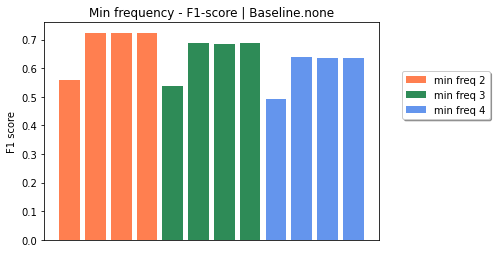

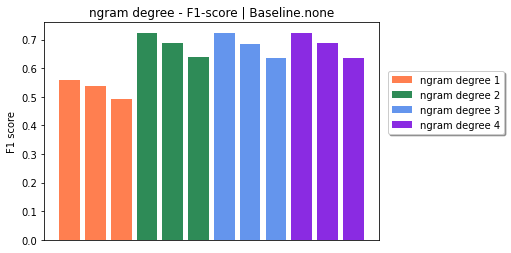

In [54]:
plot_metrics(Baseline.none)

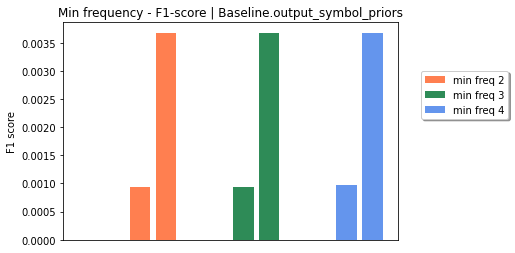

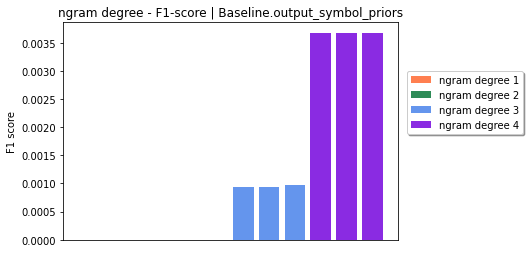

In [55]:
plot_metrics(Baseline.output_symbol_priors)

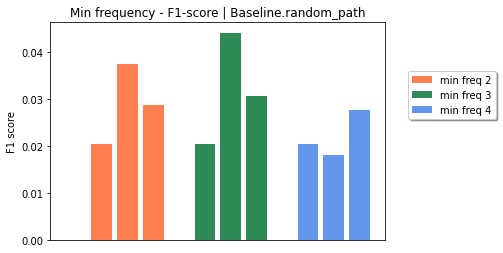

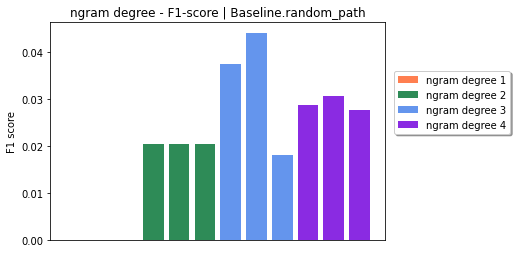

In [56]:
plot_metrics(Baseline.random_path)

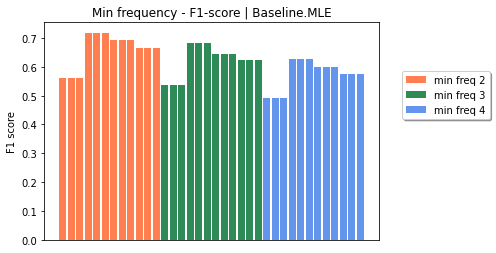

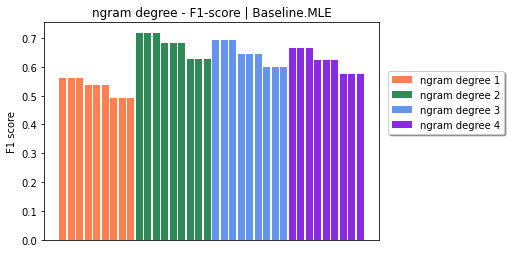

In [57]:
plot_metrics(Baseline.MLE)

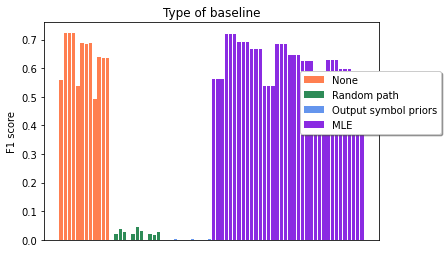

In [58]:
degrees = [
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.none), results)) ],
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.random_path), results)) ],
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.output_symbol_priors), results)) ],
    [ x['f1'] for x in list(filter(lambda i: str(i['baseline']) == str(Baseline.MLE), results)) ]
]

for v in range(1, len(degrees) + 1):
    plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])

plt.title('Type of baseline')
plt.ylabel('F1 score')
plt.legend(labels=['None', 'Random path', 'Output symbol priors', 'MLE'], 
           loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.xticks([])
plt.show()

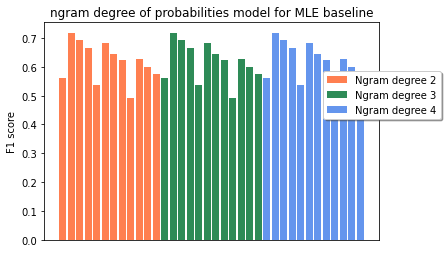

In [59]:
dt = list(filter(lambda i: str(i['baseline']) == str(Baseline.MLE), results))

values = list(set([ i['prob_ngram_degree'] for i in dt ]))
    
degrees = [ [ x['f1'] for x in list(filter(lambda i: i['prob_ngram_degree'] == v, dt)) ]
                for v in values ]

for v in range(1, len(values) + 1):
    plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])


plt.title('ngram degree of probabilities model for MLE baseline')
plt.ylabel('F1 score')
lbls = [ 'Ngram degree ' + str(v) for v in values ]
plt.legend(labels=lbls, loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.xticks([])
plt.show()

In [60]:
threshold = 0.6
best_SCLM = list(filter(lambda x: x['f1'] >= threshold, results))

#### Try with different smoothing methods

In [64]:
ngram_methods = ['presmoothed', 'unsmoothed', 'absolute', 'kneser_ney', 'witten_bell']
method_results = [] + best_SCLM

for sclm in tqdm(best_SCLM):
    for method in ngram_methods:
        method_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                                baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
                                           ngram_method=method))

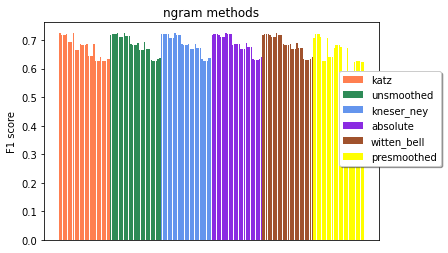

In [65]:
values = list(set([ i['ngram_method'] for i in method_results ]))
    
degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_method'] == v, method_results)) ]
                for v in values ]

for v in range(1, len(values) + 1):
    plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])


plt.title('ngram methods')
plt.ylabel('F1 score')
plt.legend(labels=values, loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
plt.xticks([])
plt.show()

In [68]:
best_SCLM_smoothed = sorted(method_results, key=lambda x: x['f1'], reverse=True)[:30]

### Compute without OoS

In [113]:
oos_results = []

for sclm in tqdm(best_SCLM_smoothed):
    oos_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                         baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
                         ngram_method=sclm['ngram_method'], remove_oos=True))

0.725883476599809 0.7248450166905103 -0.001038459909298739
0.7256214149139578 0.724236641221374 -0.0013847736925838294
0.7253688719657306 0.7231208372978115 -0.0022480346679191188
0.7253688719657306 0.7237280076081788 -0.0016408643575518411
0.7246653919694074 0.7239732569245464 -0.0006921350448609864
0.7238095238095239 0.7196573060447407 -0.00415221776478325
0.723384030418251 0.7220902612826604 -0.001293769135590539
0.7223744292237443 0.7810120913569188 0.05863766213317456
0.7223744292237443 0.7810120913569188 0.05863766213317456
0.7223744292237443 0.7810120913569188 0.05863766213317456
0.7223282442748091 0.7199999999999999 -0.0023282442748092658
0.7221693625118936 0.720532319391635 -0.0016370431202585856
0.7221464301955435 0.8090090090090091 0.0868625788134656
0.7221464301955435 0.8090090090090091 0.0868625788134656
0.7221464301955435 0.8090090090090091 0.0868625788134656
0.7219837863614689 0.7223282442748091 0.000344457913340257
0.7205479452054794 0.7803131991051453 0.059765253899665

In [114]:
oos_results_sorted = sorted(oos_results, key=lambda x: x['f1'], reverse=True)

In [115]:
print("Best SCLM after removing OoS:\n", oos_results_sorted[0])

Best SCLM after removing OoS: {'acc': 0.939159758325137, 'prec': 0.7953941541186891, 'recall': 0.8230980751604033, 'f1': 0.8090090090090091, 'min_freq': 2, 'baseline': <Baseline.MLE: 3>, 'ngram_degree': 4, 'prob_ngram_degree': 2, 'ngram_method': 'absolute', 'model_info': [['# of states', ' 9664'], ['# of ngram arcs', ' 17034'], ['# of backoff arcs', ' 9663'], ['initial state', ' 1'], ['unigram state', ' 0'], ['# of final states', ' 2225'], ['ngram order', ' 4'], ['# of 1-grams', '487'], ['# of 2-grams', '3431'], ['# of 3-grams', '6700'], ['# of 4-grams', '8641']], 'norm_rules': []}


### Apply normalization

In [481]:
normalizations = [] + norm_rules

compute_SCLM(min_freq=2, ngram_degree=4, 
                         baseline=Baseline.MLE, prob_ngram_degree=2, 
                         ngram_method='absolute',  remove_oos=True)['f1']
#norm_rules=normalizations,

0.8099099099099099

In [404]:
compute_SCLM(min_freq=2, ngram_degree=4, 
                         baseline=Baseline.MLE, prob_ngram_degree=2, 
                         ngram_method='absolute', norm_rules=normalizations, remove_oos=True, 
                d=2, m='katz')['f1']

0.7560640732265448

In [405]:
compute_SCLM(min_freq=2, ngram_degree=4, 
                         baseline=Baseline.MLE, prob_ngram_degree=2, 
                         ngram_method='absolute', norm_rules=normalizations, remove_oos=True, 
                d=3, m='kneser_ney')['f1']

0.7553726566072246

In [408]:
for m in tqdm(['katz', 'presmoothed', 'unsmoothed', 'absolute', 'kneser_ney', 'witten_bell']):
    for d in range(4, 6):
        r = compute_SCLM(min_freq=2, ngram_degree=4, 
                             baseline=Baseline.MLE, prob_ngram_degree=2, 
                             ngram_method='kneser_ney', norm_rules=normalizations, remove_oos=True, 
                    d=d, m=m)['f1']
        print(r, m, d)

0.7727690892364305 katz 4
0.7727690892364305 katz 5
0.7706422018348623 presmoothed 4
0.7706422018348623 presmoothed 5
0.7628676470588235 unsmoothed 4
0.7663293468261269 unsmoothed 5
0.7741935483870969 absolute 4
0.7741935483870969 absolute 5
0.7736284001844167 kneser_ney 4
0.7727063162747809 kneser_ney 5
0.7741935483870969 witten_bell 4
0.7738369415016122 witten_bell 5



In [ ]:
for m in tqdm(['kneser_ney', 'absolute']):
    for d in range(4, 5):
        r = compute_SCLM(min_freq=2, ngram_degree=4, 
                             baseline=Baseline.MLE, prob_ngram_degree=2, 
                             ngram_method='kneser_ney', norm_rules=normalizations, remove_oos=True, 
                    d=d, m=m)['f1']
        print(r, m, d)

# 0.7913


In [631]:
compute_SCLM(min_freq=2, ngram_degree=4, 
                             baseline=Baseline.MLE, prob_ngram_degree=2, 
                             ngram_method='kneser_ney', norm_rules=normalizations, remove_oos=True, 
                    d=4, m='kneser_ney', show_table=True)['table']

# katz = 0.782
# absolute = 0.782

# 0.797

,p,r,f,s
movie.language,0.817,0.710,0.760,69
actor.nationality,1.000,1.000,1.000,1
producer.name,0.800,0.767,0.783,73
award.category,1.000,0.000,0.000,2
director.name,0.604,0.716,0.655,81
character.name,0.769,0.667,0.714,15
movie.location,0.333,0.286,0.308,7
director.nationality,1.000,0.000,0.000,1
award.ceremony,0.571,0.571,0.571,7
movie.genre,0.698,0.833,0.759,36


In [497]:
compute_SCLM(min_freq=2, ngram_degree=4, 
                             baseline=Baseline.MLE, prob_ngram_degree=2, 
                             ngram_method='kneser_ney', remove_oos=True, 
                    d=4, m='kneser_ney', show_table=True)['table']

,p,r,f,s
movie.language,0.803,0.710,0.754,69
actor.nationality,1.000,1.000,1.000,1
producer.name,0.815,0.726,0.768,73
award.category,1.000,0.000,0.000,2
director.name,0.775,0.765,0.770,81
character.name,0.625,0.667,0.645,15
movie.location,0.400,0.286,0.333,7
director.nationality,1.000,0.000,0.000,1
award.ceremony,0.571,0.571,0.571,7
movie.genre,0.714,0.833,0.769,36


In [919]:
compute_SCLM(min_freq=2, ngram_degree=4, 
                             baseline=Baseline.MLE, prob_ngram_degree=2, 
                             ngram_method='kneser_ney', remove_oos=True, 
                    d=4, m='kneser_ney', show_table=True)['table']

,p,r,f,s
movie.language,0.803,0.710,0.754,69
actor.nationality,1.000,1.000,1.000,1
producer.name,0.815,0.726,0.768,73
award.category,1.000,0.000,0.000,2
director.name,0.775,0.765,0.770,81
character.name,0.625,0.667,0.645,15
movie.location,0.400,0.286,0.333,7
director.nationality,1.000,0.000,0.000,1
award.ceremony,0.571,0.571,0.571,7
movie.genre,0.714,0.833,0.769,36


In [343]:
ris = []

for sclm in tqdm(oos_results_sorted[:15]):
    for d in range(2, 5):
        for m in ngram_methods:
            ris.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                         baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
                         ngram_method=sclm['ngram_method'], norm_rules=normalizations, remove_oos=True, 
                            d=d, m=m))
            print(ris[-1]['f1'], ris[-1]['f1'] - sclm['f1'])

OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symbols
0.7185039370078741 -0.090505072001135
OK symbols
OK symbols
0.7185039370078741 -0.090505072001135
OK symbols
OK symbols
0.7182266009852218 -0.09078240802378723
OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symbols
0.7185039370078741 -0.090505072001135
OK symbols
OK symbols
0.704780680137999 -0.10422832887101008
OK symbols
OK symbols
0.7182266009852218 -0.09078240802378723
OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symbols
0.7185039370078741 -0.090505072001135
OK symbols
OK symbols
0.704780680137999 -0.10422832887101008
OK symbols
OK symbols
0.7182266009852218 -0.09078240802378723
OK symbols
OK symbols
0.7168882323978337 -0.09212077661117535
OK symbols
OK symb

KeyboardInterrupt: 

In [ ]:
norm_results = []
normalizations = [] + norm_rules

for sclm in tqdm(oos_results_sorted):
    #for norm in normalizations:
    #    norm_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
    #                     baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
    #                     ngram_method=sclm['ngram_method'], norm_rules=[norm], remove_oos=True))
    #    print(norm, sclm['f1'], norm_results[-1]['f1'], norm_results[-1]['f1'] - sclm['f1'])
    
    norm_results.append(compute_SCLM(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                         baseline=sclm['baseline'], prob_ngram_degree=sclm['prob_ngram_degree'], 
                         ngram_method=sclm['ngram_method'], norm_rules=normalizations, remove_oos=True))
    print(sclm['f1'], norm_results[-1]['f1'], norm_results[-1]['f1'] - sclm['f1'])

In [ ]:
def plot_norm(norm):
    values = list(set([ i['ngram_method'] for i in best_SCLM_smoothed ]))

    degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_method'] == v, best_SCLM_smoothed)) ]
                    for v in values ]

    for v in range(1, len(values) + 1):
        plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], color=b_colors[v-1])

    degrees = [ [ x['f1'] for x in list(filter(lambda i: i['ngram_method'] == v and norm == i['norm_rules']
                                               , norm_results)) ]
                    for v in values ]

    for v in range(1, len(values) + 1):
        plt.bar(range(start(degrees, v-1), start(degrees, v)), degrees[v-1], 
                color=b_colors[len(values) + v-1], alpha=0.7)


    plt.title('Comparison with normalization')
    plt.ylabel('F1 score')
    lbls = values + [ i + ' normalized by ' + ' '.join(norm) for i in values ]
    plt.legend(labels=lbls, loc='upper right', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)
    plt.xticks([])
    plt.show()

In [ ]:
for norm in normalizations:
    plot_norm([norm])
    
plot_norm(normalizations)

## Let's start finding the best parameters for HMM

In [1070]:
res = compute_HMM()
res['f1']

0.717369970559372

In [1074]:
prob_estimators = [FreqDist, ConditionalFreqDist, ConditionalProbDist, DictionaryProbDist,
    DictionaryConditionalProbDist, LidstoneProbDist, MutableProbDist, RandomProbDist]

prob_estimators = [
    lambda fd, bins: LidstoneProbDist(fd, 0.1, bins),
    lambda fd, bins: LidstoneProbDist(fd, 0.12, bins),
    lambda fd, bins: LidstoneProbDist(fd, 0.14, bins),
    lambda fd, bins: LidstoneProbDist(fd, 0.16, bins),
    lambda fd, bins: LidstoneProbDist(fd, 0.18, bins),
]

for e in tqdm(prob_estimators):
    r = compute_HMM(estimator=e)
    print(r['f1'], r['acc'], r['prec'], r['recall'])

0.7213565536205316 0.9130251510467894 0.7213565536205316 0.7213565536205316
0.7141544117647058 0.9114795559926936 0.7161290322580646 0.7121906507791017
0.7099447513812155 0.9107770127862863 0.7132284921369103 0.7066911090742438
0.7078341013824886 0.9100744695798791 0.7117701575532901 0.7039413382218148
0.7069681587448085 0.9095124350147534 0.7118959107806692 0.7021081576535289

